# Cleaning and Merging the Rossman Datasets

This notebook overviews how to clean, manipulate and merge data for the Rossman stores.

You should enter this notebook with two datasets.

* A set with data on the characteristics of each Rossman store, this set will be referred to as 'store_data'
* A set with daily sales data for each Rossman store, this set will be referred to as 'sales_data'

Follow the prompts below, at the bottom of the notebook you'll be rewarded with a fresh clean dataset 
ready for modelling.

As all good Python programs start, we will first import our packages

In [158]:
import pandas as pd

In [159]:
import numpy as np

## Cleaning Store_Data Dataset first

In [160]:
store_data = pd.read_csv('store.csv')

Some competitor stores are reaalllllly far away. We're going to assume that those stores 
aren't really offering much in the way of competition

Let's look for rows where all Competition values are null, i.e there is no competition distance nor any dates 
for competition opening. We will make the assumption that these stores have NEVER had competition

In [161]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Then let's also look for rows where CompetitionDistance exists but other competition values are zero.
We will make the assumption that these stores have had competition throughout their entire lifetime.

In [162]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()][store_data.CompetitionDistance > 0].head()

/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


So, we want a 'Competition Open Date' to signify when the store started to have competition
We will assume that a store has never gone from 'having' competition to 'not having' competition.

Given the above, we will make the following adjustments to the dataset:

* if CompDistance is null -> we want the competition date to be in the past
* if CompDistance exists, but other comp values are null -> we want comp date to be in the future
* otherwise, we will generate a date value from the competitionOpenSince columns

Once we merge the datasets we can use these dates to generate boolean values for whether a store had competition on any given day.

In [163]:
idx_of_stores_with_no_competition = store_data[store_data['CompetitionDistance'].isnull()].index
idx_of_stores_with_competition_always = store_data[store_data['CompetitionOpenSinceMonth'].isnull()][store_data.CompetitionDistance > 0].index

mask = store_data.index.isin(idx_of_stores_with_no_competition.append(idx_of_stores_with_competition_always))

idx_of_stores_where_competition_opened = store_data[~mask].index

/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [164]:
store_data.loc[idx_of_stores_with_no_competition,'competitionOpenDate'] = '01/01/2050'
store_data.loc[idx_of_stores_with_competition_always,'competitionOpenDate'] = '01/01/1970'

store_data['CompetitionOpenSinceMonth'] = store_data['CompetitionOpenSinceMonth'].fillna(0).astype(int)
store_data['CompetitionOpenSinceYear'] = store_data['CompetitionOpenSinceYear'].fillna(0).astype(int)

for index in idx_of_stores_where_competition_opened:
    
    store_data.at[index,'competitionOpenDate'] = \
        (str(store_data.at[index,'CompetitionOpenSinceMonth']) + '/15/' + str(store_data.at[index,'CompetitionOpenSinceYear']))

store_data['competitionOpenDate'] = pd.to_datetime(store_data['competitionOpenDate'])

Now, we need to do a similar exercise for the promo2 dates.

The stores can be divided into the following two categories:

* Stores that have never run promos 
* Stores that started running promos at some stage and now run promos at specific intervals

So, we need to find a 'promo2StartDate' for each store. This date will be set as far in the future for the stores that have not run promos. For the others, we must generate the 'promo2StartDate' from the other Promo date columns.

In [165]:
idx_of_stores_with_no_promo = store_data[store_data['Promo2SinceWeek'].isnull()].index

mask = store_data.index.isin(idx_of_stores_with_no_promo)
idx_of_stores_with_promos = store_data[~mask].index

In [166]:
store_data.loc[idx_of_stores_with_no_promo,'promo2StartDate'] = '01/01/2050'

store_data['Promo2SinceWeek'] = store_data['Promo2SinceWeek'].fillna(0).astype(int)
store_data['Promo2SinceYear'] = store_data['Promo2SinceYear'].fillna(0).astype(int)

for index in idx_of_stores_with_promos:
    store_data.loc[index,'promo2StartDate'] = (str(min(12,(((store_data.at[index,'Promo2SinceWeek'] * 7) // 30)+1)))\
                                               + '/15/' + str(store_data.at[index,'Promo2SinceYear']))
    
store_data['promo2StartDate'] = pd.to_datetime(store_data['promo2StartDate'])

Next step - setting stores with no competition distance to zero so that we don't have NaNs filter 
through to our final array!

In [167]:
store_data['CompetitionDistance'] = store_data['CompetitionDistance'].fillna(0)

Finally, we can one hot encode our categorical columns (StoreType and Assortment)

In [168]:
storeType_one_hot = pd.get_dummies(store_data['StoreType'])
storeType_one_hot = storeType_one_hot.rename(columns={'a': 'storeType_a', 'b': 'storeType_b',\
                                                 'c': 'storeType_c','d': 'storeType_d'}).reset_index(drop=True)

Assortment_one_hot = pd.get_dummies(store_data['Assortment'])
Assortment_one_hot = Assortment_one_hot.rename(columns={'a': 'Assortment_a', 'b': 'Assortment_b',\
                                                 'c': 'Assortment_c'}).reset_index(drop=True)

store_data = pd.concat([store_data, storeType_one_hot, Assortment_one_hot], axis=1)

## Cleaning sales_data Dataset

Now to clean the daily sales data set.

In [169]:
sales_data = pd.read_csv('new_train.csv')
sales_data.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,0,1,5,2015-07-31,5263,555,1,1,0,1
1,1,2,5,2015-07-31,6064,625,1,1,0,1
2,2,3,5,2015-07-31,8314,821,1,1,0,1
3,3,4,5,2015-07-31,13995,1498,1,1,0,1
4,4,5,5,2015-07-31,4822,559,1,1,0,1


First, we can drop the seemingly irrelevant unnamed column and replace the StateHoliday values as we did above.

In [170]:
sales_data.drop("Unnamed: 0", axis=1, inplace=True)

And next, let's hot encode the StateHoliday column

In [171]:
StateHoliday_one_hot = pd.get_dummies(sales_data['StateHoliday'])

StateHoliday_one_hot = StateHoliday_one_hot.rename(columns={'a': 'public_holiday', 'b': 'easter',\
                                                 'c': 'christmas'}).reset_index(drop=True)

StateHoliday_one_hot = StateHoliday_one_hot[['public_holiday', 'easter', 'christmas']]

sales_data = pd.concat([sales_data , StateHoliday_one_hot], axis = 1)

sales_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,public_holiday,easter,christmas
0,1,5,2015-07-31,5263,555,1,1,0,1,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0,0
5,6,5,2015-07-31,5651,589,1,1,0,1,0,0,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,0,0,0
7,8,5,2015-07-31,8492,833,1,1,0,1,0,0,0
8,9,5,2015-07-31,8565,687,1,1,0,1,0,0,0
9,10,5,2015-07-31,7185,681,1,1,0,1,0,0,0


Then, let's lose these days with no sales i.e. days when the stores are shut.

In [172]:
sales_data = sales_data[sales_data['Sales'] > 0]

Finally, we can play with the Dates - ensuring that the date column is a datetime, and adding columns for the 
day, month and year.

In [173]:
sales_data['Date']=pd.to_datetime(sales_data['Date'])

/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [174]:
# add columns of day month and year as int
sales_data['day'] = pd.DatetimeIndex(sales_data['Date']).day
sales_data['month'] = pd.DatetimeIndex(sales_data['Date']).month
sales_data['year'] = pd.DatetimeIndex(sales_data['Date']).year

/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mackdelany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Merging Two Datasets

Now that we've cleaned our two tables, we're ready to merge them together:

In [175]:
merged_dataset = sales_data.merge(store_data, how='left', left_on='Store',right_on='Store')
merged_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,public_holiday,...,PromoInterval,competitionOpenDate,promo2StartDate,storeType_a,storeType_b,storeType_c,storeType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,0,...,NaN,2008-09-15,2050-01-01,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,0,...,"Jan,Apr,Jul,Oct",2007-11-15,2010-04-15,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,0,...,"Jan,Apr,Jul,Oct",2006-12-15,2011-04-15,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,...,NaN,2009-09-15,2050-01-01,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,0,...,NaN,2015-04-15,2050-01-01,1,0,0,0,1,0,0


We've combined the sales activity with store characteristics about competition. This means we can now denote
whether a store had competition on any given day.

We simply do this by comparing the sales activity date with the date of launch for a stores competition:

In [176]:
merged_dataset['Competition'] = (merged_dataset.competitionOpenDate <= merged_dataset.Date).astype(int)
merged_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,public_holiday,...,competitionOpenDate,promo2StartDate,storeType_a,storeType_b,storeType_c,storeType_d,Assortment_a,Assortment_b,Assortment_c,Competition
0,1,5,2015-07-31,5263,555,1,1,0,1,0,...,2008-09-15,2050-01-01,0,0,1,0,1,0,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,0,...,2007-11-15,2010-04-15,1,0,0,0,1,0,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,0,...,2006-12-15,2011-04-15,1,0,0,0,1,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,0,...,2009-09-15,2050-01-01,0,0,1,0,0,0,1,1
4,5,5,2015-07-31,4822,559,1,1,0,1,0,...,2015-04-15,2050-01-01,1,0,0,0,1,0,0,1


Next, and a little less simply, we need to identify whether a store had a second promo (promo2) running
on any given day.

We do this by first extracting integers for the months in which stores had campaigns active:

In [177]:
from time import strptime

merged_dataset['PromoInterval'] = merged_dataset['PromoInterval'].fillna('no_promo').astype(str)

def get_month_integers_from_month_strings(month_strings):
    if month_strings == 'no_promo':
        return 0
    else:
        month_array = []
        month_list = month_strings.split(",") 
        for month in month_list:
            if len(month) == 4:
                month_array.append(9)
            else:
                month_array.append(strptime(month,'%b').tm_mon)

        return month_array

merged_dataset['promoMonths'] = merged_dataset['PromoInterval'].apply(get_month_integers_from_month_strings)

Following that, we can extract the month out of the date column. This will be a temporary column which we will 
use to identify whether a store has a promo2 running:

In [178]:
def get_month(date):
    return date.month   

merged_dataset['month_test'] = merged_dataset['Date'].apply(get_month)

Now that we've extracted the above values, we can compare them!

The below for loop runs through each day of sales activity for each store. If the date of activity is after the 
store's promo2 launch date, and if the month of activity is one of the months in which it runs promo2, then
the store will be denoted as running promo2 on that particular day.

In [179]:
for index in range(merged_dataset.shape[0]):
    if isinstance(merged_dataset.at[index, 'promoMonths'],list) :
        if (merged_dataset.at[index, 'promo2StartDate'] <= merged_dataset.at[index, 'Date'])\
                & (merged_dataset.at[index, 'month_test'] in merged_dataset.at[index, 'promoMonths'] ):
            merged_dataset.at[index, 'promoMonths'] = 1
    else :
        merged_dataset.at[index,'Promo2'] = 0
    
merged_dataset['Promo2'] = merged_dataset['Promo2'].astype(int)


Ok. Let's clean up after ourselves and drop the columns we don't want!

In [180]:
final_dataset = merged_dataset[['Store','DayOfWeek','day','month','year','Sales','Customers','Open','Promo',\
                                'SchoolHoliday', 'CompetitionDistance', 'Competition','Promo2', 
                                'storeType_a','storeType_b', 'storeType_c', 'storeType_d', 'Assortment_a',
                               'Assortment_b', 'Assortment_c', 'public_holiday', 'easter', 'christmas']]

Exciting times, here's a quick look at our cleaned up dataset:

In [183]:
final_dataset.head()

,Store,DayOfWeek,day,month,year,Sales,Customers,Open,Promo,SchoolHoliday,...,storeType_a,storeType_b,storeType_c,storeType_d,Assortment_a,Assortment_b,Assortment_c,public_holiday,easter,christmas
0,1,5,31,7,2015,5263,555,1,1,1,...,0,0,1,0,1,0,0,0,0,0
1,2,5,31,7,2015,6064,625,1,1,1,...,1,0,0,0,1,0,0,0,0,0
2,3,5,31,7,2015,8314,821,1,1,1,...,1,0,0,0,1,0,0,0,0,0
3,4,5,31,7,2015,13995,1498,1,1,1,...,0,0,1,0,0,0,1,0,0,0
4,5,5,31,7,2015,4822,559,1,1,1,...,1,0,0,0,1,0,0,0,0,0


Alrighty, download the file and be on your way:

In [ ]:
final_dataset.to_csv(r'cleaned_training_set.csv')

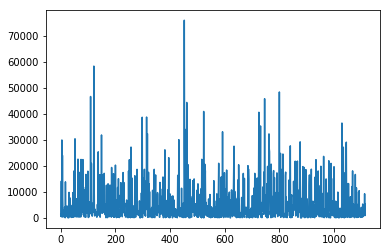

In [61]:
import matplotlib
%matplotlib inline
data = store_data.CompetitionDistance.plot()

In [63]:
final_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StoreType,Assortment,StateHoliday,SchoolHoliday,CompetitionDistance,Competition,Promo2
0,1,5,2015-07-31,5263,555,1,1,2,0,0,1,1270.0,1,0
1,2,5,2015-07-31,6064,625,1,1,0,0,0,1,570.0,1,1
2,3,5,2015-07-31,8314,821,1,1,0,0,0,1,14130.0,1,1
3,4,5,2015-07-31,13995,1498,1,1,2,2,0,1,620.0,1,0
4,5,5,2015-07-31,4822,559,1,1,0,0,0,1,29910.0,1,0
